# Starbucks Capstone Challenge

## Table of Contents
<ul>
<li><a href="#overview">Project Overview</a></li>
<li><a href="#analysis">Analysis</a></li>
<li><a href="#methodology">Methodology</a></li>
<li><a href="#results">Results</a></li>
<li><a href="#conclusion">Conclusion</a></li>
</ul>

<a id='overview'></a>
## Project Overview

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

### Problem Statement:
In this project i will resolve some question about dataset and lastly predict response user action on event like "offer view", "offer completed" base on attributes of provided dataset. Some question are:
* How distribution of user groups
* How customer react to offer
* Which gender most react to offer
* Which gender is the most in each age group.
* Which offer type is the most react


### Metrices
To evaluate model performance, i plan to use the accuracy with K-Nearest Neighbors model.

<a id='analysis'></a>
## Analysis

### Data Exploration

In [249]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
# limit 10000 rows for quick processing
# transcript = pd.read_json('data/transcript.json', orient='records', lines=True, nrows=10000)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [250]:
# Exploring porfolio dataset
print('portfolio',portfolio.shape)
print(portfolio.info())
portfolio.head()

portfolio (10, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes
None


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


> The dataset has 10 rows, 6 columns with no null value. There are 3 offer_type bogo, information, discount. In this dataset, i would like to change id column name to offer_id for more meaning and link to transcript dataset later.

In [251]:
# Exploring profile dataset
print('profile',profile.shape)
print(profile.info())
profile.head()

profile (17000, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB
None


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


> The dataset has 17000 rows, 5 columns with gender, income have null value. these null data can be remove because we don't know real gender and incom of customers. we can add age_group column to classify age to multiple customer groups. This will make to have more accurate recommendations.

In [252]:
# Exploring transcript dataset
print('transcript',transcript.shape)
print(transcript.info())
transcript.head()

transcript (306534, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB
None


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


> The dataset has 306534 rows, 4 columns with no null value. value column is in json type. It should be separate to multiple columns included offer_id column to link with portfolio dataset.

<a id='methodology'></a>
## Methodology
### Data preprocessing
1.  Porfolio dataset have no null value. For better recommendations, i would like change id column to offer_id column to link with transcript dataset. Also, i want to create offer_name column for clearer meaning for recommendations.

2. profile dataset have null value and for purpose of statements above, there are 2 jobs to process:
    - clean null value. in this case i will choose to remove rows with null value because there is not information about which gender, which income to fill in this case.   
    - add age_group column to table to separate people to multiple groups, which are good for recommendations.
    
3. transcript dataset have no null value. For better recommendations, i would like to get only customers who viewed and completed offer. So, in this dataset, there are some step to preprocessing:
    - filter data to get only viewed and completed offer.
    - separate value column to multiple columns included offer_id column to link with porfolio dataset
4. merge cleaned 3 dataset above to one dataset, clean merged dataset to start analysis

#### preprocessing portfolio data

In [253]:
# create copy dataset
portfolio_clean = portfolio.copy()
# rename column id to offer_id
portfolio_clean.rename(columns={"id": "offer_id"}, errors="raise", inplace = True)
# add offer_name column to make statistics and recommendations base on this columns:
portfolio_clean['offer_name']= portfolio_clean.apply(lambda x: '_'.join([str(x['offer_type']),str(x['difficulty']),str(x['duration'])]), axis=1)
portfolio_clean.head()

,reward,channels,difficulty,duration,offer_type,offer_id,offer_name
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,bogo_10_7
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo_10_5
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,informational_0_4
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo_5_7
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount_20_10


#### preprocessing profile data

In [254]:
#rename column id = person to link with transcript dataset
profile_clean = profile.copy()
profile_clean.rename(columns={"id": "person"}, errors="raise", inplace = True)
# profile dataset: clean null values in dataset
profile_clean.dropna(inplace=True)
# profile dataset: add age_group column
def group_age(age):
    """
    this function to classify age to suitable groups.
    """
    if age <20:
        return 'age_0_to_20'
    elif age <=40:
        return 'age_21_to_40'
    elif age <=60:
        return 'age_41_to_60'
    else:
        return 'age_above_60'
profile_clean['age_group'] = profile_clean.apply(lambda x: group_age(x['age']), axis=1)
# recheck dataset
print(profile_clean.info())
profile_clean.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               14825 non-null  int64  
 2   person            14825 non-null  object 
 3   became_member_on  14825 non-null  int64  
 4   income            14825 non-null  float64
 5   age_group         14825 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 810.7+ KB
None


,gender,age,person,became_member_on,income,age_group
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,age_41_to_60
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,age_above_60
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,age_above_60
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,age_above_60
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,age_41_to_60


#### preprocessing transcript data

In [255]:
# know about event column values
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [256]:
# create transcript_clean ds from transcript ds:
transcript_clean = transcript[transcript.event.isin(['offer viewed', 'offer completed'])]
transcript_clean.head()

,person,event,value,time
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0
12652,102e9454054946fda62242d2e176fdce,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
12653,02c083884c7d45b39cc68e1314fec56c,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0
12655,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0


In [257]:
# split value column to offer_id and amount column
# get keys in value column
keys = []
for value in transcript_clean['value']:
    tmp_keys = list(value.keys())
    for key in tmp_keys:
        if key not in keys:
            keys.append(key)
print(keys)
values = transcript_clean['value'].values.tolist()
df_values = pd.DataFrame(values,columns =keys)
# join offer_id and offer id to one column because they are one
df_values['offer_id'].fillna(df_values['offer id'], inplace = True)
del df_values['offer id']
# df_values[~df_values.offer_id.isnull() & ~df_values.reward.isnull()].head()
# fill amount and reward column with 0 in case null
df_values['reward'].fillna(0, inplace = True)
df_values.head()
# fill offer_id null value with unique category 'Unknown' to know it's not refer to any offer id
df_values['offer_id'].fillna('Unknown', inplace = True)
# concat transcript with df_values
del transcript_clean['value']
transcript_clean = pd.concat([transcript_clean,df_values],axis=1,join='outer')
# recheck transcript dataset to verify no null value
transcript.info()
transcript_clean.head()


['offer id', 'offer_id', 'reward']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


,person,event,time,offer_id,reward
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,0.0,fafdcd668e3743c1bb461111dcafc2a4,2.0
12652,102e9454054946fda62242d2e176fdce,offer viewed,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0
12653,02c083884c7d45b39cc68e1314fec56c,offer viewed,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0
12655,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0


#### merge all dataset and create matrix table

In [258]:
# merge all dataset
df_all = transcript_clean.merge(portfolio_clean, how='left', on='offer_id')
df_all = df_all.merge(profile_clean, how='left', on='person')
df_all.head()

,person,event,time,offer_id,reward_x,reward_y,channels,difficulty,duration,offer_type,offer_name,gender,age,became_member_on,income,age_group
0,389bc3fa690240e798340f5a15918d5c,offer viewed,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,5.0,"[web, email]",20.0,10.0,discount,discount_20_10,M,65.0,20180209.0,53000.0,age_above_60
1,d1ede868e29245ea91818a903fec04c6,offer viewed,0.0,fafdcd668e3743c1bb461111dcafc2a4,2.0,2.0,"[web, email, mobile, social]",10.0,10.0,discount,discount_10_10,O,53.0,20170916.0,52000.0,age_41_to_60
2,102e9454054946fda62242d2e176fdce,offer viewed,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,"[web, email, mobile]",5.0,7.0,bogo,bogo_5_7,F,69.0,20160814.0,57000.0,age_above_60
3,02c083884c7d45b39cc68e1314fec56c,offer viewed,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,10.0,"[web, email, mobile, social]",10.0,5.0,bogo,bogo_10_5,F,20.0,20160711.0,30000.0,age_21_to_40
4,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,"[web, email, mobile]",5.0,7.0,bogo,bogo_5_7,M,39.0,20140527.0,51000.0,age_21_to_40


In [259]:
# remove all person have null gender value because of they are removed from profile above
df_all.dropna(subset=['gender'], inplace = True)
# fill reward_y to 'Unknown' value because of link to Unknown offer_id
df_all['reward_y'].fillna('Unknown', inplace=True)
# remove column channels because it contains null value and unused in my investigation
del df_all['channels']
# fill other left null value to 0 because of datatype is number
df_all.fillna(0, inplace=True)

In [260]:
# check duplicated
df_all[df_all.duplicated()]

,person,event,time,offer_id,reward_x,reward_y,difficulty,duration,offer_type,offer_name,gender,age,became_member_on,income,age_group
14700,eee45ae2599740b19aa6d70aeabcb6c0,offer completed,168.0,2298d6c36e964ae4a3e7e9706d1fb8c2,0.0,3.0,7.0,7.0,discount,discount_7_7,M,82.0,20151014.0,78000.0,age_above_60
15743,50af1c2d62584c06ad8058ea5701fd05,offer completed,168.0,ae264e3637204a6fb9bb56bc8210ddfd,0.0,10.0,10.0,7.0,bogo,bogo_10_7,M,55.0,20150803.0,83000.0,age_41_to_60
16182,5e442aa81ab043168496fa9d8dc207f8,offer completed,168.0,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,3.0,7.0,7.0,discount,discount_7_7,F,68.0,20151020.0,101000.0,age_above_60
20660,7e795099f75645b997a137f4a63fcde4,offer completed,186.0,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0,0.0,3.0,informational,informational_0_3,M,84.0,20160904.0,37000.0,age_above_60
22201,81a3cf0f43134a70ad4a7c5ff3d575c0,offer completed,192.0,fafdcd668e3743c1bb461111dcafc2a4,0.0,2.0,10.0,10.0,discount,discount_10_10,M,80.0,20150809.0,75000.0,age_above_60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91133,655f294ab8154d3ebffaa801f241271c,offer completed,708.0,0,0.0,Unknown,0.0,0.0,0,0,F,85.0,20180324.0,108000.0,age_above_60
91171,b7e216b6472b46648272c29a52a86702,offer completed,714.0,0,0.0,Unknown,0.0,0.0,0,0,M,53.0,20180708.0,113000.0,age_41_to_60
91189,0222d267445f4f078bc325224e471766,offer completed,714.0,0,0.0,Unknown,0.0,0.0,0,0,M,64.0,20180102.0,43000.0,age_above_60
91220,e00e39e41bf64361a81f0c82da3c3ead,offer completed,714.0,0,0.0,Unknown,0.0,0.0,0,0,F,52.0,20180426.0,90000.0,age_41_to_60


In [261]:
# remove duplicated
df_all.drop_duplicates(inplace = True)

In [262]:
def add_column_mapping(df, destName, baseName):
    """
    mapping string category column to number column with target column name = destName base on column baseName
    """
    ids = df[baseName].unique()
    target_dict = pd.Series(ids).to_dict()
    target_dict = dict([(value, key) for key, value in target_dict.items()])
    df_all[destName] = df_all[baseName].map(target_dict)
add_column_mapping(df_all, 'gender_mapping', 'gender')
# add column column mapping event
add_column_mapping(df_all, 'event_mapping', 'event')
# add column column mapping offer_type
add_column_mapping(df_all, 'offer_type_mapping', 'offer_type')
# add column column mapping offer_type
add_column_mapping(df_all, 'offer_name_mapping', 'offer_name')
# add column column mapping age_group
add_column_mapping(df_all, 'age_group_mapping', 'age_group')
# add column column mapping gender
add_column_mapping(df_all, 'gender_mapping', 'gender')
df_all.head()

,person,event,time,offer_id,reward_x,reward_y,difficulty,duration,offer_type,offer_name,gender,age,became_member_on,income,age_group,gender_mapping,event_mapping,offer_type_mapping,offer_name_mapping,age_group_mapping
0,389bc3fa690240e798340f5a15918d5c,offer viewed,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,5.0,20.0,10.0,discount,discount_20_10,M,65.0,20180209.0,53000.0,age_above_60,0,0,0,0,0
1,d1ede868e29245ea91818a903fec04c6,offer viewed,0.0,fafdcd668e3743c1bb461111dcafc2a4,2.0,2.0,10.0,10.0,discount,discount_10_10,O,53.0,20170916.0,52000.0,age_41_to_60,1,0,0,1,1
2,102e9454054946fda62242d2e176fdce,offer viewed,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,5.0,7.0,bogo,bogo_5_7,F,69.0,20160814.0,57000.0,age_above_60,2,0,1,2,0
3,02c083884c7d45b39cc68e1314fec56c,offer viewed,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,10.0,10.0,5.0,bogo,bogo_10_5,F,20.0,20160711.0,30000.0,age_21_to_40,2,0,1,3,2
4,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,5.0,7.0,bogo,bogo_5_7,M,39.0,20140527.0,51000.0,age_21_to_40,0,0,1,2,2


> now we have a merged clean table contains all data about viewed and completed offers.

### Implement

#### How distribution of user groups?

In [263]:
def drawBarChart(data, title, yLabel, xLabel, figSize=(10,8), rotate = 0):
    """
    This function is reused when draw bar chart.
    Parameters:
        data: data input
        title: title of the chart
        yLabel: label of y axis
        xLabel: label of x axis
    """
    
    chart = data.plot(kind='bar', title=title, figsize= figSize, rot = rotate)
    chart.set_ylabel(yLabel)
    chart.set_xlabel(xLabel)

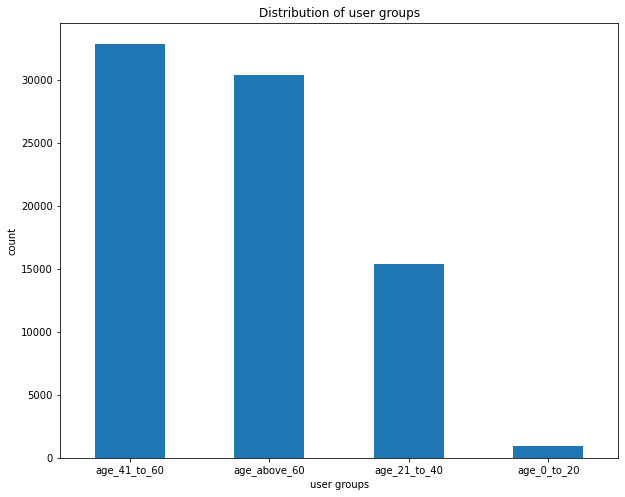

In [264]:
data = df_all.age_group.value_counts()
drawBarChart(data, 'Distribution of user groups','count','user groups')

> as above visualization, user in the age from 41 to 60 is the most in dataset.

#### How customer react to offer


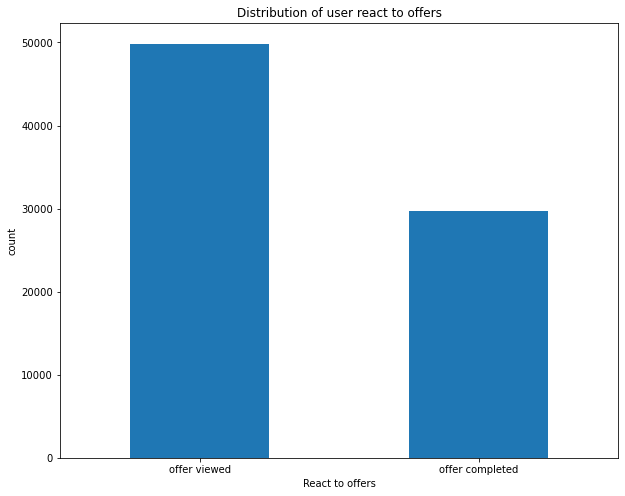

In [265]:
data = df_all.event.value_counts()
drawBarChart(data, 'Distribution of user react to offers','count','React to offers')

> most people view offer.

#### Distribution of gender react to offers

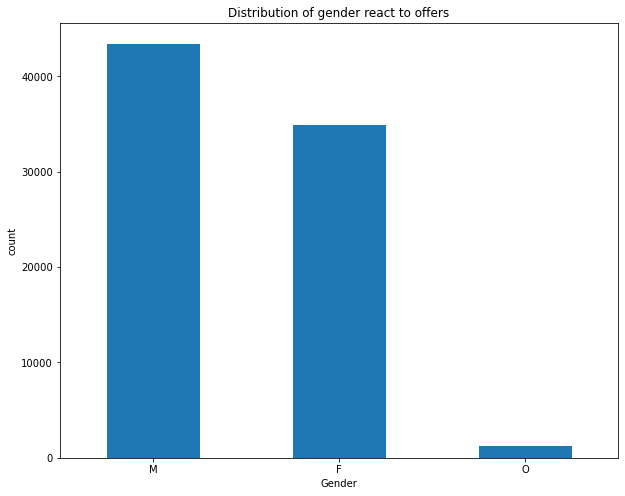

In [266]:
data = df_all.gender.value_counts()
drawBarChart(data, 'Distribution of gender react to offers', 'count', 'Gender')

> Gender Male reacts the most.

#### Distribution of user groups react to offers

In [267]:
df_all.gender.value_counts()

M    43418
F    34932
O     1237
Name: gender, dtype: int64

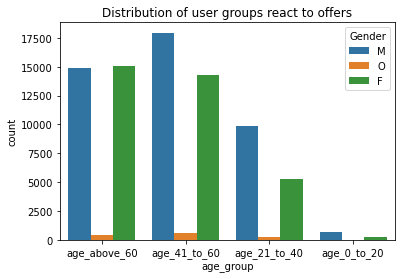

In [268]:
# get data for filter conditions
# sns.barplot(data=df_all, x="event", y="age", hue="gender")
g = sns.countplot(x='age_group', hue="gender", data= df_all)
plt.title('Distribution of user groups react to offers')
plt.ylabel = 'Total'
plt.xlabel= 'user groups'
plt.legend(title='Gender')
plt.show();

> In each group, gender Male alway reacts the most.

#### Which offer type is the most react

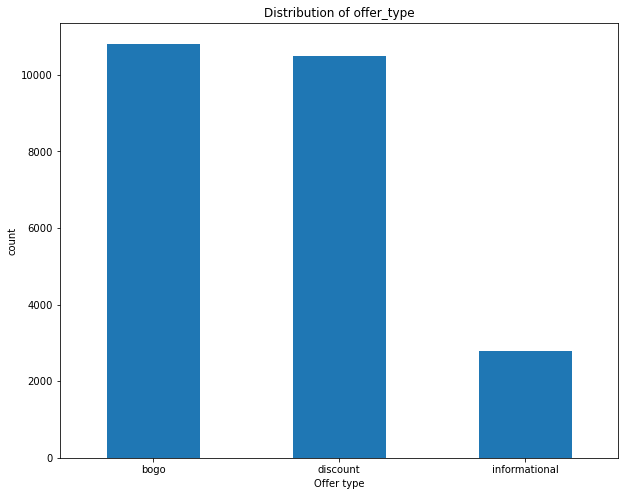

In [269]:
# Which offer type is the most react
data = df_all[df_all.offer_type !=0].offer_type.value_counts()
drawBarChart(data, 'Distribution of offer_type', 'count', 'Offer type')

> BOGO is the most offer people take care.

### Modeling & Prediction

In [270]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79587 entries, 0 to 91303
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   person              79587 non-null  object 
 1   event               79587 non-null  object 
 2   time                79587 non-null  float64
 3   offer_id            79587 non-null  object 
 4   reward_x            79587 non-null  float64
 5   reward_y            79587 non-null  object 
 6   difficulty          79587 non-null  float64
 7   duration            79587 non-null  float64
 8   offer_type          79587 non-null  object 
 9   offer_name          79587 non-null  object 
 10  gender              79587 non-null  object 
 11  age                 79587 non-null  float64
 12  became_member_on    79587 non-null  float64
 13  income              79587 non-null  float64
 14  age_group           79587 non-null  object 
 15  gender_mapping      79587 non-null  int64  
 16  even

In [271]:
# create X, Y data
X = df_all[['time','reward_x','difficulty','duration','became_member_on','income',\
                'offer_type_mapping','offer_name_mapping','age_group_mapping', 'gender_mapping']]
Y = df_all['event_mapping']

In [272]:
# create train, test data
X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((63669, 10), (15918, 10), (63669,), (15918,))

<a id='results'></a>
## Results

### Model Evaluation and Validation

In [273]:
def evaluate_model(model):
    '''
    evaludate model and printing classify report.
    '''
    y_pred = model.predict(X_test)
    evaluate_report = classification_report(y_test, y_pred)
    print(evaluate_report)

In [274]:
# define model
kn_model = KNeighborsClassifier()
kn_model.fit(X_train, y_train)
# evaluate  KNeighborsClassifier model
evaluate_model(kn_model)

              precision    recall  f1-score   support

           0       0.60      0.71      0.65      9974
           1       0.29      0.20      0.23      5944

    accuracy                           0.52     15918
   macro avg       0.44      0.45      0.44     15918
weighted avg       0.48      0.52      0.49     15918



### Justification
Now i will try with SVC model to compare with KNeighborsClassifier model

In [275]:
# evaluate  SVC model
svc_model = SVC()
svc_model.fit(X_train, y_train)
evaluate_model(svc_model)

              precision    recall  f1-score   support

           0       0.63      1.00      0.77      9974
           1       0.00      0.00      0.00      5944

    accuracy                           0.63     15918
   macro avg       0.31      0.50      0.39     15918
weighted avg       0.39      0.63      0.48     15918



/Users/minhnt34/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/minhnt34/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/minhnt34/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


> As result above, we see that KNeighborsClassifier have more accuracy.

<a id='conclusion'></a>
## Conclusion

For the result above, now we can conclusion:
- user in the age from 41 to 60 is the most customers of Starbucks.
- Gender Male reacts the most.
- customer like view offer more than completed it.
- BOGO is the most offer people take care.
- In each group, gender Male alway reacts the most.
- We can use KNeighborsClassifier model but the accuracy still low. I think if we do better in cleaning data, the result maybe better.